In [1]:
import os
import sys
from glob import glob

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shared.utils as su

### Load data

In [2]:
data_root = "/scratch/shared/beegfs/piyush/datasets/MSRVTT"
video_dir = f"{data_root}/videos/all/"

In [ ]:
data = su.io.load_json(f"{data_root}/annotation/msrvtt_test_1k.json")
df = pd.DataFrame(data)

In [ ]:
df['video_path'] = df.video.apply(lambda x: f"{video_dir}/{x}")
df['video_path'].apply(os.path.exists).mean()

text_col = "caption"
df.shape

In [3]:
df.iloc[0].to_dict()

{'video_id': 'video7020',
 'video': 'video7020.mp4',
 'caption': 'a woman creating a fondant baby and flower',
 'source': 'MSR-VTT',
 'category': 10,
 'url': 'https://www.youtube.com/watch?v=4KRMJNBjrEs',
 'start time': 221.77,
 'end time': 233.08,
 'id': 7020,
 'video_path': '/scratch/shared/beegfs/piyush/datasets/MSRVTT/videos/all//video7020.mp4'}

15.215650000000002


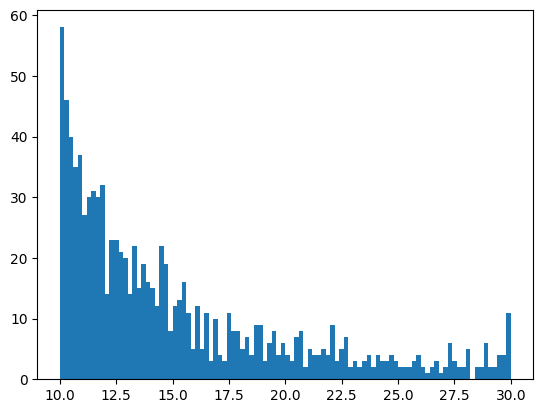

In [4]:
df['duration'] = df['end time'] - df['start time']
print(df['duration'].mean())
plt.hist(df['duration'], bins=100);

### Qwen3VL-Embedding-8B

In [5]:
from models.qwen3vl_embedding import Qwen3VLEmbedder

model_name_or_path = "/work/piyush/pretrained_checkpoints/Qwen3-VL-Embedding-8B/"
model = Qwen3VLEmbedder(
    model_name_or_path=model_name_or_path,
    torch_dtype=torch.float16,
    attn_implementation="flash_attention_2",
    device_map="cuda:0",
)
su.misc.num_params(model.model)

`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

::: Number of total parameters in Qwen3VLForEmbedding: 8144.794M


In [9]:
def gather_text_features(model, texts: list):
    """Compute text embeddings for all unique text IDs."""
    texts_feat = {}
    for j, text in enumerate(
        su.log.tqdm_iterator(texts, desc='Computing text features')
    ):
        emb = model.process([{'text': text}])
        zt = emb.squeeze(0).cpu().float()
        texts_feat[text] = zt
        if j == 0:
            print("Text embedding:", zt.shape)
    return texts_feat


def gather_video_features(model, video_paths: list, num_frames=8):
    """Compute video embeddings for all unique video IDs."""
    video_feat = {}
    for j, video_path in enumerate(
        su.log.tqdm_iterator(video_paths, desc='Computing video features')
    ):
        emb = model.process([{
            'video': video_path,
            # num_frames: samples frames uniformly ignoring FPS
            # If this is passed, max_frames is also ignored
            'num_frames': num_frames,
        }])
        zv = emb.squeeze(0).cpu().float()
        video_feat[video_path] = zv
        if j == 0:
            print("Video embedding:", zv.shape)
    return video_feat

### Qwen 3 VL

In [87]:
from models.qwen3vl import EncoderForQwen3VL

model_path = "/work/piyush/pretrained_checkpoints/Qwen3-VL-8B-Instruct/"
model = EncoderForQwen3VL.from_pretrained(
    model_path, dtype=torch.bfloat16, device_map="auto", attn_implementation="flash_attention_2",
)
su.misc.num_params(model.model)

Loading EncoderForQwen3VL from /work/piyush/pretrained_checkpoints/Qwen3-VL-8B-Instruct/


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

The module name  (originally ) is not a valid Python identifier. Please rename the original module to avoid import issues.


::: Number of total parameters in Qwen3VLForConditionalGeneration: 8767.124M


In [89]:
from utils.video import read_frames_decord

In [88]:
model.encode_text('sample').shape

torch.Size([1, 4096])

In [97]:
def gather_text_features(model, texts: list):
    """Compute text embeddings for all unique text IDs."""
    texts_feat = {}
    for j, text in enumerate(
        su.log.tqdm_iterator(texts, desc='Computing text features')
    ):
        emb = model.encode_text(text)
        zt = emb.squeeze(0).cpu().float()
        texts_feat[text] = zt
        if j == 0:
            print("Text embedding:", zt.shape)
    return texts_feat


def gather_video_features(model, video_paths: list, num_frames=8):
    """Compute video embeddings for all unique video IDs."""
    video_feat = {}
    for j, video_path in enumerate(
        su.log.tqdm_iterator(video_paths, desc='Computing video features')
    ):
        try:
            frames = read_frames_decord(video_path=video_path, num_frames=num_frames)
        except:
            print(f"Failed reading {video_path}. Using dummy inputs.")
            frames = torch.zeros((num_frames, 3, 256, 256), dtype=int)
        emb = model.encode_vision(frames.unsqueeze(0))

        # emb = model.process([{
        #     'video': video_path,
        #     # num_frames: samples frames uniformly ignoring FPS
        #     # If this is passed, max_frames is also ignored
        #     'num_frames': num_frames,
        # }])

        zv = emb.squeeze(0).cpu().float()
        video_feat[video_path] = zv
        if j == 0:
            print("Video embedding:", zv.shape)
    return video_feat

In [95]:
frames = read_frames_decord(video_path='../../TimeBound.v1/sample_data/folding_paper.mp4', num_frames=8)
frames.shape

torch.Size([8, 3, 240, 426])

In [ ]:
frames = read_frames_decord(video_path='/scratch/shared/beegfs/piyush/datasets/MSRVTT/videos/all//video7212.mp4', num_frames=8)
frames.shape

### Compute embeddings

In [91]:
texts_embeds = gather_text_features(model, df[text_col].unique())
len(texts_embeds)

Computing text features:   0%|          | 0/995 [00:00<?, ?it/s]

Text embedding: torch.Size([4096])


995

In [94]:
video_embeds = gather_video_features(model, df.video_path.unique())
len(video_embeds)

Computing video features:   0%|          | 0/1000 [00:00<?, ?it/s]

Asked to sample `fps` frames per second but no video metadata was provided which is required when sampling with `fps`. Defaulting to `fps=24`. Please provide `video_metadata` for more accurate results.


Video embedding: torch.Size([4096])


[12:00:00] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /scratch/shared/beegfs/piyush/datasets/MSRVTT/videos/all//video7212.mp4, Remote I/O error


RuntimeError: Error reading /scratch/shared/beegfs/piyush/datasets/MSRVTT/videos/all//video7212.mp4...

In [11]:
# Save
save_dir = "/work/piyush/experiments/CaRe/embeddings"
# torch.save(video_embeds, f"{save_dir}/video_embeds-qwne3vlembedding8b-msrvtt.pt")
# torch.save(texts_embeds, f"{save_dir}/texts_embeds-qwne3vlembedding8b-msrvtt.pt")
torch.save(video_embeds, f"{save_dir}/video_embeds-qwne3vl_eol-msrvtt.pt")
torch.save(texts_embeds, f"{save_dir}/texts_embeds-qwne3vl_eol-msrvtt.pt")

In [12]:
vid2text = {}
for f in video_embeds:
    vid2text[f] = df[df.video_path == f].iloc[0][text_col]
len(vid2text)

1000

In [77]:
X = []
Y = [] 
for i in range(len(df)):
    row = df.iloc[i].to_dict()
    zv = video_embeds[row['video_path']]
    zt = texts_embeds[row[text_col]]
    # g = zv - zt
    # G.append(g)
    X.append(zv)
    Y.append(zt)

# G = torch.stack(G)
norm = lambda x: torch.nn.functional.normalize(x, dim=-1)
X = norm(torch.stack(X))
Y = norm(torch.stack(Y))
delta = np.round((X.mean(dim=0) - Y.mean(dim=0)).norm(dim=-1).item(), 2)
delta

0.23

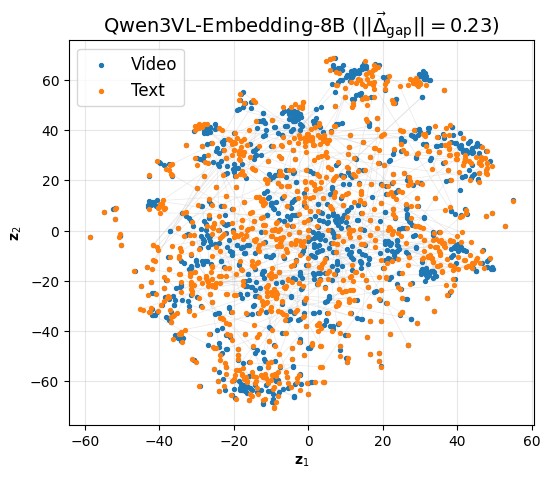

In [79]:
def visualize_modality_gap(_video_embeds: dict, _texts_embeds: dict, vid2text: dict, method='tsne', save_path=None, title='Modality Gap'):
    norm = lambda x: torch.nn.functional.normalize(x, dim=-1)
    ZV = torch.stack([_video_embeds[f] for f in _video_embeds])
    ZT = torch.stack([_texts_embeds[t] for t in _texts_embeds])
    Z = torch.concatenate([ZV, ZT], dim=0)
    Z = norm(Z)
    z = su.visualize.reduce_dim(Z, method=method)

    # Create mappings from video/text to their index in z
    video_list = list(_video_embeds.keys())
    text_list = list(_texts_embeds.keys())
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    
    # Draw matching lines first (so they appear behind the points)
    for i, f in enumerate(video_list):
        matched_text = vid2text[f]
        if matched_text in text_list:
            j = text_list.index(matched_text)
            # Draw line from video point to text point
            ax.plot([z[i, 0], z[len(ZV) + j, 0]], 
                    [z[i, 1], z[len(ZV) + j, 1]], 
                    color='lightgray', linewidth=0.5, alpha=0.5, zorder=1)
    
    # Draw scatter points on top
    ax.scatter(z[:len(ZV), 0], z[:len(ZV), 1], s=8, label='Video', zorder=2)
    ax.scatter(z[len(ZV):, 0], z[len(ZV):, 1], s=8, label='Text', zorder=2)
    
    ax.grid(alpha=0.3)
    ax.set_xlabel("$\\mathbf{z}_{1}$")
    ax.set_ylabel("$\\mathbf{z}_{2}$")
    ax.legend(fontsize=12)
    ax.set_title(title, fontsize=14)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


visualize_modality_gap(video_embeds, texts_embeds, vid2text, title="Qwen3VL-Embedding-8B ($|| \\vec{\Delta}_{\\text{gap}}|| = %s $)" % delta, method='tsne', save_path='../figures/qwen3vlembedding8b-msrvtt-modgap.pdf')

tensor(0.2282)

**Compute measures**

In [21]:
# G = []
X = []
Y = [] 
for i in range(len(df)):
    row = df.iloc[i].to_dict()
    zv = video_embeds[row['video_path']]
    zt = texts_embeds[row[text_col]]
    # g = zv - zt
    # G.append(g)
    X.append(zv)
    Y.append(zt)

# G = torch.stack(G)
norm = lambda x: torch.nn.functional.normalize(x, dim=-1)
X = norm(torch.stack(X))
Y = norm(torch.stack(Y))
G = X - Y
g_mean = torch.mean(G, dim=0)

In [63]:
from shared.utils.embedding_distances import embedding_distance, print_comparison

metrics = embedding_distance(X, Y)

print_comparison(metrics, metrics, "Qwen3VL-Embedding-8B", "NA")

  Metric                         Qwen3VL-Embedding-8B                    NA
--------------------------------------------------------------------------
  centroid_cosine_similarity                 0.871608              0.871608
  centroid_euclidean_distance                0.228221              0.228221
  emd_euclidean                              0.970222              0.970222
  emd_cosine                                 0.474922              0.474922
  mmd_rbf                                    0.059835              0.059835
  kl_xy                                    873.606660            873.606660
  kl_yx                                    951.329638            951.329638
  js_divergence                            912.468149            912.468149
  frechet_distance                           0.304082              0.304082
  silhouette_euclidean                       0.015822              0.015822
  silhouette_cosine                          0.030690              0.030690
  calinski_ha

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_hist_with_distribution(ax, values, nbins=100):
    """
    Plot histogram with smooth KDE curve and mean line.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axis to plot on.
    values : array-like
        1D numeric data.
    nbins : int, optional
        Number of histogram bins (default=100).
    """
    values = np.asarray(values)
    values = values[np.isfinite(values)]  # remove NaNs/Infs

    # Histogram (density normalized)
    ax.hist(values, bins=nbins, density=True, alpha=0.5, label="Histogram")

    # KDE curve
    kde = gaussian_kde(values)
    x = np.linspace(values.min(), values.max(), 1000)
    ax.plot(x, kde(x), linewidth=2, label="KDE")

    # Mean line
    mean_val = values.mean()
    ax.axvline(mean_val, linestyle="--", linewidth=2,
               label=f"Mean = {mean_val:.3f}")

    ax.legend()
    ax.set_ylabel("Density")
    ax.set_xlabel("Value")


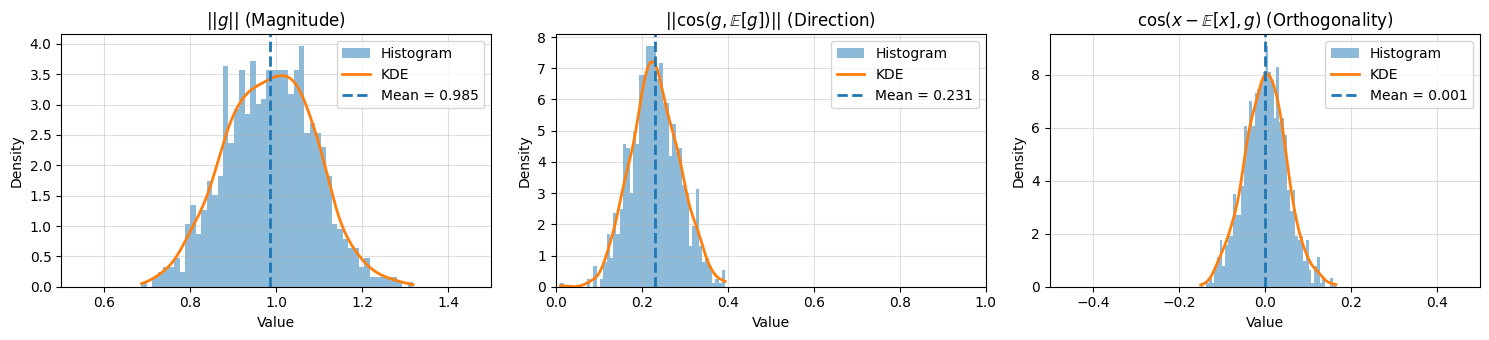

In [81]:
axwidth = 5
axheight = 3.5
ncols = 3
nrows = 1

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * axwidth, nrows * axheight))

ax = axes[0]
ax.grid(alpha=0.4)
plot_hist_with_distribution(ax, G.norm(dim=-1), nbins=50)
ax.set_xlim(0.5, 1.5)
ax.set_title("$ || g || $ (Magnitude)")


ax = axes[1]
ax.grid(alpha=0.4)
vals = torch.cosine_similarity(G, G.mean(dim=0, keepdims=True))
plot_hist_with_distribution(ax, vals, nbins=50)
ax.set_title("$ || \cos(g, \mathbb{E}[g]) || $ (Direction)")
ax.set_xlim(0, 1)

ax = axes[2]
ax.grid(alpha=0.4)
vals = torch.cosine_similarity(X - X.mean(dim=0, keepdims=True), G.mean(dim=0, keepdims=True))
plot_hist_with_distribution(ax, vals, nbins=50)
ax.set_xlim(-0.5, 0.5)
ax.set_title("$\cos(x - \mathbb{E}[x], g)$ (Orthogonality)")

plt.tight_layout()
save_path='../figures/qwen3vlembedding8b-msrvtt-stats.pdf'
plt.savefig(save_path, bbox_inches="tight")
plt.show()